In [1]:
import pandas as pd
import random
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.manifold import Isomap
from sklearn.decomposition import TruncatedSVD

In [2]:
def import_data(data_dir="../../data"):
    metadata_file = "metadata_df.pkl"
    metadata_df = pd.read_pickle(os.path.join(data_dir, metadata_file))
    audio_file = "audio_features_df_{mid_window_5.0,mid_step_0.5,short_window_1.0,short_step_0.5}.pkl"
    audio_df = pd.read_pickle(os.path.join(data_dir, audio_file))
    audio_df = audio_df.drop(['beat_conf'], axis=1)
    video_file = "video_features_df_{ftlist_[lbps,hogs,colors,flow],width_300,step_3}.pkl"
    video_df = pd.read_pickle(os.path.join(data_dir, video_file))
    return metadata_df, audio_df, video_df

In [3]:
def my_train_test_split(percentage, df):
    test_idx_list = list()
    test_url_list = list()

    original_list_of_indexes = list(df.index.values)

    total_items, _ = df.shape
    required_test_items = np.round(percentage*total_items)

    while len(test_idx_list)<required_test_items:
        #select random item
        item_idx = random.choice(original_list_of_indexes)
        item_url = df.at[item_idx, "Url"]
        if item_url not in test_url_list:
            test_url_list.append(item_url)
            test_idx_list.extend(list(df.index[df['Url'] == item_url]))

    train_idx_list = [x for x in original_list_of_indexes if x not in test_idx_list]

    return train_idx_list, test_idx_list

In [4]:
def create_not_matching_entries(num_of_entries, metadata, indexes):
    mappings = {}
    videos = random.sample(indexes, num_of_entries)
    for video in videos:
        candidates = metadata[metadata["Url"] == metadata.at[video, "Mismatch URL"]]
        mappings[video] = random.choice(candidates.index)
    return mappings

In [5]:
def get_feature_target_arrays(audio_df, metadata_df, train_list, video_df):

    
    video_train = video_df.loc[train_list]
    audio_train = audio_df.loc[train_list]
    
    X_train_match = np.hstack((video_train.values, audio_train.values))
    Y_train_match = np.ones((X_train_match.shape[0], 1))
    train_no_match_mapping = create_not_matching_entries(X_train_match.shape[0],
                                                              metadata_df, train_list)
    X_train_no_match = np.hstack((video_df.loc[train_no_match_mapping.keys()].values,
                                  audio_df.loc[train_no_match_mapping.values()].values))
    Y_train_no_match = np.zeros((X_train_no_match.shape[0], 1))
    X_train = np.vstack((X_train_match, X_train_no_match))
    Y_train = np.vstack((Y_train_match, Y_train_no_match)).ravel()
    X_train, Y_train = shuffle(X_train, Y_train, random_state=2020)

    return X_train, Y_train

def create_train_test_splits(percentage, metadata_df, audio_df,
                             video_df, num_of_splits=20):
    splits = []

    for split_num in range(num_of_splits):
        random.seed(2020 + 2*split_num)
        train_list, test_list = my_train_test_split(percentage, metadata_df)

        X_train, Y_train = get_feature_target_arrays(audio_df, metadata_df, train_list, video_df)
        X_test, Y_test = get_feature_target_arrays(audio_df, metadata_df, test_list, video_df)

        splits.append({"X_train": X_train, "Y_train": Y_train, "X_test": X_test, "Y_test": Y_test})

    return splits

In [6]:
def normalize_df(df):
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
    return scaled_df, scaler

In [7]:
def reduce_dimensions_svd(in_df:pd.DataFrame, new_dimension:int):
    """
    Method to reduce the features in a dataframe
    using Multidimensional scaling
    :param in_df: Input dataframe
    :param new_dimension: Number of output features
    :return: Reduced dataframe, reducer
    """
    reducer = TruncatedSVD(n_components=new_dimension, random_state=2020)
    out_df = pd.DataFrame(reducer.fit_transform(in_df.values),
                          index=in_df.index)

    return out_df, reducer

In [8]:
metadata_df, audio_df, video_df = import_data()

In [9]:
from math import sqrt
norm_video_df, _ = normalize_df(video_df)
norm_audio_df, _ = normalize_df(audio_df)

trans_video_df, _ = reduce_dimensions_svd(norm_video_df, round(sqrt(norm_video_df.shape[0])))
trans_audio_df, _ = reduce_dimensions_svd(norm_audio_df, round(sqrt(norm_audio_df.shape[0])))

splits = create_train_test_splits(0.2, metadata_df, trans_audio_df, trans_video_df)

models = {'Baseline': DummyClassifier(strategy="stratified", random_state=2020),
          'kNN': KNeighborsClassifier(),
          'DT':  DecisionTreeClassifier(random_state=2020),
          'NB':  GaussianNB(),
          'SVM': SVC(random_state=2020),
          'RF' : RandomForestClassifier(random_state=2020)}

scores = {model_name: [] for model_name in models.keys()}

for model_name, model in models.items():
    fit_times = []
    testing_times = []
    
    for split in splits:
        start_time = time.time()
        model.fit(split["X_train"], split["Y_train"])
        fit_time = time.time() - start_time

        start_time = time.time()
        Y_predict = model.predict(split["X_test"])
        score = accuracy_score(split["Y_test"], Y_predict)
        testing_time = time.time() - start_time
        
        fit_times.append(fit_time)
        testing_times.append(testing_time)
        scores[model_name].append(score)
    
    print("{name:9} accuracy: {score:.3f} time to fit: {time:8.3f}"
          "sec test time: {time_test:8.3f}sec".format(name=model_name,
                                                      score=np.median(scores[model_name]),
                                                      time=np.median(fit_times),
                                                      time_test=np.median(testing_times)))

Baseline  accuracy: 0.477 time to fit:    0.000sec test time:    0.001sec
kNN       accuracy: 0.530 time to fit:    0.005sec test time:    0.056sec
DT        accuracy: 0.468 time to fit:    0.064sec test time:    0.000sec
NB        accuracy: 0.475 time to fit:    0.001sec test time:    0.001sec
SVM       accuracy: 0.543 time to fit:    0.244sec test time:    0.051sec
RF        accuracy: 0.384 time to fit:    0.679sec test time:    0.012sec


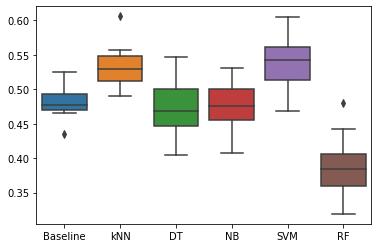

In [10]:
sns.boxplot(data=pd.DataFrame.from_dict(scores))
plt.savefig("classifiers.png")

In [11]:
from sklearn.model_selection import GridSearchCV

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ["linear", "poly", "rbf", "sigmoid"]
param_grid = {'C': Cs, 'gamma' : gammas, "kernel": kernels}
grid_search = GridSearchCV(SVC(random_state=2020), param_grid, cv=2, scoring="accuracy", n_jobs=3)
grid_search.fit(splits[0]["X_train"], splits[0]["Y_train"])
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.001, 'gamma': 1, 'kernel': 'poly'}
0.5534591194968553


In [12]:
f_model = SVC(**grid_search.best_params_, random_state=2020, probability=True)

In [13]:
f_model.fit(split["X_train"], split["Y_train"])

SVC(C=0.001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=2020, shrinking=True, tol=0.001,
    verbose=False)

In [14]:
trans_video_new = trans_video_df[:1]
suggestions = []

for audio in trans_audio_df.iterrows():
    x = np.hstack((trans_video_new.values,
                   audio[1].values.reshape(1,len(audio[1]))))
            
    probs = model.predict_proba(x).ravel().tolist()
    max_prob = max(probs)
    if probs.index(max_prob) == 1:
        suggestions.append((audio[0], max_prob))

In [15]:
print(sorted(suggestions, key=lambda t: t[1])[0][0])

13b6b16358c12d08f263cd3eafa3f67a
